In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import numpy.linalg as la

## Some useful functions

In [2]:
def to_homg(x):
    """
    Transform x to homogeneous coordinates
    Если X размера MxN, возвращает массив размера (M+1)xN  
    с единичками в последней строке
    
    >>> to_homg(np.array([[1, 2, 3], [1, 2, 3]], dtype=float))
    array([[ 1.,  2.,  3.],
           [ 1.,  2.,  3.],
           [ 1.,  1.,  1.]])
    >>> to_homg(np.array([[1], [2]]))
    array([[ 1.],
           [ 2.],
           [ 1.]])
    >>> to_homg([1, 2])
    array([1, 2, 1])
    """
    if hasattr(x, 'shape') and len(x.shape) > 1:
        return np.r_[x, np.ones((1,x.shape[1]))]
    else:
        return np.r_[x, 1]

def from_homg(x):
    """
    Transform homogeneous x to non-homogeneous coordinates
    If X is MxN, returns an (M-1)xN array that will contain nan when for
    columns where the last row was 0
    >>> from_homg(np.array([[1, 2, 3],
    ...                     [4, 5, 0]], dtype=float))
    array([[ 0.25,  0.4 ,   nan]])
    >>> from_homg(np.array([1, 5], dtype=float))
    array([ 0.2])
    >>> from_homg([1, 5, 0])
    array([ nan,  nan])
    >>> from_homg((1, 4, 0.5))end = time.time()
    array([ 2.,  8.])
    """
    if hasattr(x, 'shape') and len(x.shape) > 1:
        #valid = np.nonzero(x[-1,:])
        valid = x[-1,:] != 0
        result = np.empty((x.shape[0]-1, x.shape[1]), dtype=float)
        result[:,valid] = x[:-1,valid] / x[-1, valid]
        result[:,~valid] = np.nan
        return result
    else:
        if x[-1] == 0:
            result = np.empty(len(x)-1, dtype=float)
            result[:] = np.nan
            return result
        else:
            return np.array(x[:-1]) / x[-1]

In [3]:
def rectify_shearing(H1, H2, imsize):
    """Compute shearing transform than can be applied after the rectification
    transform to reduce distortion.
    See :
    http://scicomp.stackexchange.com/questions/2844/shearing-and-hartleys-rectification
    "Computing rectifying homographies for stereo vision" by Loop & Zhang
    
    Loop & Zhang present a solution: 
    They use a shearing transform to reduce the distortion introduced 
    by the projective transform that mapped the epipoles to infinity 
    (ie, that made the epipolar lines parallel).
    """
    w = imsize[0]
    h = imsize[1]

    a = ((w-1)/2., 0., 1.)
    b = (w-1., (h-1.)/2., 1.)
    c = ((w-1.)/2., h-1., 1.)
    d = (0., (h-1.)/2., 1.)

    ap = from_homg(H1.dot(a))
    bp = from_homg(H1.dot(b))
    cp = from_homg(H1.dot(c))
    dp = from_homg(H1.dot(d))

    x = bp - dp
    y = cp - ap

    k1 = (h*h*x[1]*x[1] + w*w*y[1]*y[1]) / (h*w*(x[1]*y[0] - x[0]*y[1]))
    k2 = (h*h*x[0]*x[1] + w*w*y[0]*y[1]) / (h*w*(x[0]*y[1] - x[1]*y[0]))

    if k1 < 0:
        k1 *= -1
        k2 *= -1

    return np.array([[k1, k2, 0],
                     [0, 1, 0],
                     [0, 0, 1]], dtype=float)

In [4]:
def rectify_uncalibrated(lines1, lines2, x1, x2, F, imsize, threshold=5):
    """
    Compute rectification homography for two images. This is based on
    algo 11.12.3 of HZ2 --- из книги Hartley, Zisserman "Multiple view geometry in computer vision" (second edition)
    ( http://cvrs.whu.edu.cn/downloads/ebooks/Multiple%20View%20Geometry%20in%20Computer%20Vision%20(Second%20Edition).pdf )
    
    очень похоже на этот алгоритм http://vision-cdc.csiro.au/changs/doc/sun12ivcnz.pdf
    
    This is also heavily inspired by cv::stereoRectifyUncalibrated
    
    Args:
        - imsize is (width, height)
    """
    U, W, V = la.svd(F) #singular value decomposition for F
    # Enforce rank 2 on fundamental matrix
    W[2] = 0
    W = np.diag(W)
    F = U.dot(W).dot(V)    

    # Compute H = GRT where :
    # - T is a translation taking point x0 to the origin
    # - R is a rotation about the origin taking the epipole e' to (f,0,1)
    # - G is a mapping taking (f,0,1) to infinity

    # e2 is the left null vector of F (the one corresponding to the singular
    # value that is 0 => the third column of U)
    e2 = U[:,2]

    # TODO: They do this in OpenCV, not sure why
    if e2[2] < 0:
        e2 *= -1

    # Translation bringing the image center to the origin
    # FIXME: This is kind of stupid, but to get the same results as OpenCV,
    # use cv.Round function, which has a strange behaviour :
    # cv.Round(99.5) => 100
    # cv.Round(132.5) => 132
    # cx = cv2.Round((imsize[0]-1)*0.5)
    cx = np.round((imsize[0]-1)*0.5)
    # cy = cv2.Round((imsize[1]-1)*0.5)
    cy = np.round((imsize[1]-1)*0.5)

    T = np.array([[1, 0, -cx],
                  [0, 1, -cy],
                  [0, 0, 1]], dtype=float)

    e2 = T.dot(e2)
    mirror = e2[0] < 0

    # Compute rotation matrix R that should bring e2 to (f,0,1)
    # 2D norm of the epipole, avoid division by zero
    d = max(np.sqrt(e2[0]*e2[0] + e2[1]*e2[1]), 1e-7)
    alpha = e2[0]/d
    beta = e2[1]/d
    R = np.array([[alpha, beta, 0],
                  [-beta, alpha, 0],
                  [0, 0, 1]], dtype=float)

    e2 = R.dot(e2)

    # Compute G : mapping taking (f,0,1) to infinity
    invf = 0 if abs(e2[2]) < 1e-6*abs(e2[0]) else -e2[2]/e2[0]
    G = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [invf, 0, 1]], dtype=float)

    # Map the origin back to the center of the image
    iT = np.array([[1, 0, cx],
                   [0, 1, cy],
                   [0, 0, 1]], dtype=float)

    H2 = iT.dot(G.dot(R.dot(T)))

    # HZ2 11.12.2 : Find matching projective transform H1 that minimize
    # least-square distance between reprojected points
    e2 = U[:,2]

    # TODO: They do this in OpenCV, not sure why
    if e2[2] < 0:
        e2 *= -1

    e2_x = np.array([[0, -e2[2], e2[1]],
                     [e2[2], 0, -e2[0]],
                     [-e2[1], e2[0], 0]], dtype=float)

    e2_111 = np.array([[e2[0], e2[0], e2[0]],
                       [e2[1], e2[1], e2[1]],
                       [e2[2], e2[2], e2[2]]], dtype=float)

    H0 = H2.dot(e2_x.dot(F) + e2_111)

    # Minimize \sum{(a*x_i + b*y_i + c - x'_i)^2} (HZ2 p.307)
    # Compute H1*x1 and H2*x2    
    x1h = to_homg(x1)
    x2h = to_homg(x2)
    try:
        A = H0.dot(x1h).T
    except ValueError:
        print( "Error, TODO: Why this kind of dimensions (H0*x1), need to transpose pts1?")
        print( " H0 dim: " + str(H0.shape))
        print( "  x2h dim: " + str(x1h.shape))
        A = H0 # nothing done

    # We want last (homogeneous) coordinate to be 1 (coefficient of c
    # in the equation)
    A = (A.T / A[:,2]).T # for some reason, A / A[:,2] doesn't work
    try:
        B = H2.dot(x2h)
    except ValueError:
        print("Error, TODO: Why this kind of dimensions (H2*x2), need to transpose pts2?")
        print(" H2 dim: " + str(H2.shape))
        print("  x1h dim: " + str(x1h.shape))
        B = H2 # nothing done
        
    B = B / B[2,:] # from homogeneous
    B = B[0,:] # only interested in x coordinate

    X, _, _, _ = la.lstsq(A, B)

    # Build Ha (HZ2 eq. 11.20)
    Ha = np.array([[X[0], X[1], X[2]],
                   [0, 1, 0],
                   [0, 0, 1]], dtype=float)

    H1 = Ha.dot(H0)

    if mirror:
        mm = np.array([[-1, 0, cx*2],
                       [0, -1, cy*2],
                       [0, 0, 1]], dtype=float)
        H1 = mm.dot(H1)
        H2 = mm.dot(H2)

    return H1, H2

In [5]:
def rectify_images(img1, pts1, img2, pts2, F, shearing=False):
    
    imsize = (img1.shape[1], img1.shape[0])
    
    H1, H2 = rectify_uncalibrated(lines1, lines2, pts1, pts2, F, (img1.shape[1], img1.shape[0]))
    # Camera Matrix --- 
    # Preferly I don't know it --- Нужна для функции cv2.initUndistortRectifyMap
    cx = img1.shape[1] / 2
    cy = img1.shape[0] / 2
    f = 0.8*cx
    K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
    
    # Distortion
    d = 0 # Assume no distortion
    
    #x1_1d = np.empty((2*x1.shape[1],), dtype=float)
    #x1_1d[0::2] = x1[0,:]
    #x1_1d[1::2] = x1[1,:]

    #x2_1d = np.empty((2*x2.shape[1],), dtype=float)
    #x2_1d[0::2] = x2[0,:]
    #x2_1d[1::2] = x2[1,:]

    #success, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, imsize)


    if shearing:
        S = rectify_shearing(H1, H2, imgsize)
        H1 = S.dot(H1)

    lH = la.inv(K).dot(H1).dot(K)
    rH = la.inv(K).dot(H2).dot(K)

    # TODO: lRect or rRect for img1/img2 ??
    map1x, map1y = cv2.initUndistortRectifyMap(K, d, lH, K, imsize,
                                               cv2.CV_16SC2)
    map2x, map2y = cv2.initUndistortRectifyMap(K, d, rH, K, imsize,
                                               cv2.CV_16SC2)

    # Convert the images to RGBA (add an axis with 4 values)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2RGBA)
    img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2RGBA)
    
    rimg1 = cv2.remap(img1, map1x, map1y,
                      interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT,
                      borderValue=(0,0,0,0))
    rimg2 = cv2.remap(img2, map2x, map2y,
                      interpolation=cv2.INTER_LINEAR,
                      borderMode=cv2.BORDER_CONSTANT,
                      borderValue=(0,0,0,0))
                      

    #rimg1 = cv2.warpPerspective(img1, H1, (img1.shape[1],img1.shape[0]))
    #rimg2 = cv2.warpPerspective(img2, H2, (img2.shape[1],img2.shape[0]))
    # Put a red background on the invalid values -- (255,0,0,255)
    # Put a black background on the invalid values -- (0,0,0,255)
    if len(img1.shape) == 2: # grayscale
        # print "Grayscale for remap"
        rimg1[rimg1[:,:,3] == 0,:] = (0,0,0,255)
        rimg2[rimg2[:,:,3] == 0,:] = (0,0,0,255)
    elif len(img1.shape) == 3: # RGB
        # print "Color for remap"
        rimg1[rimg1[:,:,3] == 0,:] = (0,0,0,255)
        rimg2[rimg2[:,:,3] == 0,:] = (0,0,0,255)
    elif len(img1.shape) == 4: # RGBA
        # print "Color (RGBA) for remap"
        rimg1[rimg1[:,:,3] == 0,:] = (0,0,0,255)
        rimg2[rimg2[:,:,3] == 0,:] = (0,0,0,255)
    else:
        print( str(len(img1.shape)) + " image size / type (remap)?")

    return rimg1, rimg2

### Functions to view images

In [6]:
def show_rectified_images(rimg1, rimg2):
    plt.figure(figsize=(10,10))
    plt.title("rectified")
    ax = plt.subplot(121)
    plt.imshow(rimg1)
    sh = int(rimg1.shape[0])
    # Hack to get the lines span on the left image
    # http://stackoverflow.com/questions/6146290/plotting-a-line-over-several-graphs
    for i in range(1, rimg1.shape[0], int(sh/20)):
        plt.axhline(y=i, color='g', xmin=0, xmax=1.2, clip_on=False);
    
    plt.subplot(122)
    plt.imshow(rimg2)
    for i in range(1, rimg1.shape[0], int(sh/20)):
        plt.axhline(y=i, color='g')
        
def side_by_side_images(img1, img2):
    height = max(img1.shape[0], img2.shape[0])
    xoff = img1.shape[1]
    vimg = np.zeros((height, img1.shape[1]+img2.shape[1], 4), dtype=np.uint8)
    vimg[0:img1.shape[0], 0:img1.shape[1]] = cv2.cvtColor(img1, 0)
    vimg[0:img2.shape[0], xoff:xoff+img2.shape[1]] = cv2.cvtColor(img2, 0)
    return vimg

def draw_matches(img1, img2, x1, x2):
    vimg = side_by_side_images(img1, img2)
    xoff = img1.shape[1]
    plt.figure(figsize=(10,10))
    plt.title('matches')
    plt.imshow(vimg)
    #plt.gca().autoscale(False)

    for i in range(x1.shape[1]):
        p1 = x1[:,i]
        p2 = x2[:,i] + [xoff,0]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], '+-')

## Main

In [56]:
img1 = cv2.imread('c_2.jpg')
img2 = cv2.imread('c_3.jpg')

imgsize = (img1.shape[1], img1.shape[0])

orb = cv2.ORB_create() 

#print(img1.shape, img2.shape)
#print(img2.shape[0] == img1.shape[0])
#img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

#gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

In [57]:
# Нахождение ключевых точек (kp) 
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

###FLANN parameters
#FLANN_INDEX_KDTREE = 0
#index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#search_params = dict(checks=50)

#flann = cv2.FlannBasedMatcher(index_params,search_params)  #---  doesn't work 

# сопоставление с помощью brute force 
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(des1,des2, k=2)


good = []
pts1 = []
pts2 = []

###ratio test by Lowe paper -- https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
    # Get the matching keypoints for each of the images
    # img1_idx = m.queryIdx
    # img2_idx = m.trainIdx

    # x - columns
    # y - rows
    # Get the coordinates
    # (x1,y1) = kp1[img1_idx].pt
    # (x2,y2) = kp2[img2_idx].pt


pts1 = np.array(pts1)
pts2 = np.array(pts2)

#Вычисление фундаментальной матрицы 
# **cv2.FM_7POINT** for a 7-point algorithm. 
# **cv2.FM_8POINT** for an 8-point algorithm. 
# **cv2.FM_RANSAC** for the RANSAC algorithm. 
# **cv2.FM_LMEDS** for the LMedS algorithm. 
F, mask= cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1, 0.995)

# Select only inlier points based on fundamental matrix
pts1 = pts1[:,:][mask.ravel()==1]
pts2 = pts2[:,:][mask.ravel()==1]

p1fNew = pts1.reshape((pts1.shape[0] * 2, 1))
p2fNew = pts2.reshape((pts2.shape[0] * 2, 1))

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)

# transpose
pts1 = pts1.T
pts2 = pts2.T

rimg1, rimg2 = rectify_images(img1, pts1, img2, pts2, F, shearing=True)

#------
#H1, H2 = rectify_uncalibrated(lines1, lines2, pts1, pts2, F, (img1.shape[1], img1.shape[0]))

# ----- Try later ------
#S = rectify_shearing(H1, H2, imgsize)
#H1 = S.dot(H1)

# Init Undistort, Map (mapx / mapy)
#img1, map1x, map1y, img2, map2x, map2y = undistortMap(H1, H2, img1, img2)

# Remap
#rimg1, rimg2 = remap(img1, map1x, map1y, img2, map2x, map2y)
#------

# для сравнения, стандартная функция 
retBool ,rectmat1, rectmat2 = cv2.stereoRectifyUncalibrated(p1fNew,p2fNew,F,(img1.shape[1], img1.shape[0]))
# Init Undistort, Map (mapx / mapy)
#img1_r, map1x, map1y, img2_r, map2x, map2y = undistortMap(rectmat1, rectmat2, img1, img2)

# Remap
#rimg1_r, rimg2_r = remap(img1_r, map1x, map1y, img2_r, map2x, map2y)
dst11 = cv2.warpPerspective(img1,rectmat1,(img1.shape[1],img1.shape[0]))
dst22 = cv2.warpPerspective(img2,rectmat2,(img2.shape[1],img2.shape[0]))


c:\users\1\anaconda3\envs\cvenv\lib\site-packages\ipykernel_launcher.py:118: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


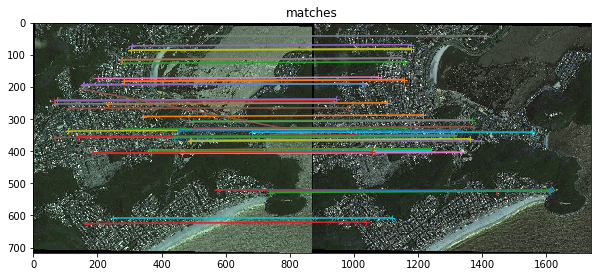

In [58]:
draw_matches(img1, img2, pts1, pts2)

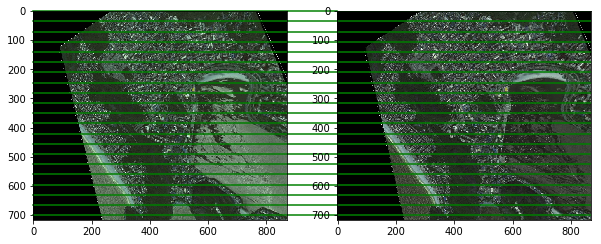

In [74]:
# отректифицированные изображения и эпиполярные линии 
show_rectified_images(rimg1, rimg2)

In [60]:
cv2.imwrite('rimg1.png', rimg1)
cv2.imwrite('rimg2.png', rimg2)

True

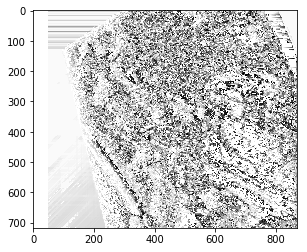

In [72]:
#calculation of the disparity
stereo = cv2.StereoSGBM_create(minDisparity = 1, numDisparities=16*3, blockSize=3)
disp = stereo.compute(rimg1[:,:,2], rimg2[:,:,2]).astype(np.float32)

plt.imshow(disp, cmap='binary')
#plt.colorbar()
#plt.clim(0,40)
#plt.show()
plt.savefig("disp.png")

## 3D Modeling

![matrix](https://psv4.userapi.com/c848236/u39350325/docs/d3/1ab519250425/image.png?extra=rz6VgAaCkKocFdpq7OD4cvlzBcPP1tl8EmZLqlqoZ5W5g-VHetrpLaz_3k5Cu0oOKvG5jlpi5tP1iZkboc18sjEL0Ug2ERXzwpeo1ARevCyjnw3xj6WX9PzA2lszkK0KuxPDzVYH7-Rgpw6RvomjDUM)

Q is the disparity-to-depth mapping matrix

In that image, 
* cx and cy are the coordinates of the principal point in the left camera (if we did stereo matching with the left camera dominant) (Просто центр изображения в нашем случае)
* c'x is the x-coordinate of the principal point in the right camera 
* f is the focal length
* Tx is the baseline length (possibly the negative of the baseline length, it's the translation from one optical centre to the other).



In [33]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
        
        
#generating 3d point cloud
disp = disp
print('generating 3d point cloud...',)
h, w = img1.shape[:2]
f = 0.8*w                   # guess for focal length

#disparity-to-depth mapping matrix
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(disp, Q)
colors = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
mask = disp > disp.mean() #с маской все работает в MeshLab, без маски - не открывает из-за наличия нулевых столбцов
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

generating 3d point cloud...
out.ply saved
